In [62]:
import numpy as np
import pandas as pd

def floor(x):
    return x * np.where(x<0,0,1)


In [63]:
def compute_paths(rawsims, hourtypes, params):
    sims = rawsims.copy()
    sims[:,2,:] = rawsims[:,2,:] + hourtypes.weekday.map(dayadj).values.reshape(-1,1)
    sims[:,2,:] = sims[:,2,:] * params['demandfactor']
    sims[:,0,:] = rawsims[:,0,:] * params['solarcapacity']
    sims[:,1,:] = rawsims[:,1,:] * params['windcapacity'] 
    ns = params['ns']
    endpath = rawsims.shape[2]-params['offset']
    startpath = endpath - ns
    sims = sims[:,:,startpath:endpath]    
    (days, f, batterygranularity, batteries,
     batteryduration) = (365, params['f'], 
                                              params['batterygranularity'],
                                              params['batteries'],
                                              params['batteryduration'])

    sims[:,3,:] = sims[:,2,:]-sims[:,1,:]-sims[:,0,:]
    sims[:,4,:] = f(floor(sims[:,3,:]))
    a = sims[:,3,:].reshape((1, days*24, ns ))
    b = np.array(list(range(-batterygranularity, batterygranularity+1))).reshape(-1,1,1)*batteries/batterygranularity
    c = a + b
    d = f(floor(c))
    e = (d[0:-1, :, :] + d[1:, :, :]  )/2
    e1 = e[0:batterygranularity,:,:].transpose((2,1,0)).reshape((-1,1))
    e2 = e[batterygranularity:,:,:].transpose((2,1,0)).reshape((-1,1))
    h=(np.ones((ns*days,1,1))*np.array(list(range(24))).reshape(1,-1,1)*np.ones((1,1,batterygranularity))).reshape(-1,1)
    e1 = np.hstack([e1,h])
    e2 = np.hstack([e2,h])
    e1 = e1.reshape((-1,batterygranularity*24,2))
    e2 = e2.reshape((-1,batterygranularity*24,2))

    ab = e1[:,:,0].argsort()
    ab = np.stack([ab,ab], axis=2)
    k = np.indices((ns*days,24*batterygranularity,2))
    e1a = e1[(k[0], ab, k[2])][:,-batterygranularity*batteryduration:,::]
    
    ab = e2[:,:,0].argsort()
    ab = np.stack([ab,ab], axis=2)
    k = np.indices((ns*days,24*batterygranularity,2))
    e2a = e2[(k[0], ab, k[2])][:,0:batterygranularity*batteryduration,::]
    
    ineff = e1a[:,::-1,0]<e2a[:,:,0]
    e1a[:,:,1] = np.where(ineff[:,::-1],-1,e1a[:,:,1])
    e2a[:,:,1] = np.where(ineff[:,:],-1, e2a[:,:,1])
    #raise Exception
    e1a = e1a[:,:,1]
    e2a = e2a[:,:,1]
    
    r = np.array(list(range(24)))   
    e1a = np.equal(r.reshape(24,1,1), e1a.reshape(1,ns*days,-1)).sum(axis=2)
    e2a = np.equal(r.reshape(24,1,1), e2a.reshape(1,ns*days,-1)).sum(axis=2)
    e1b = e1a.reshape(24,ns,days).transpose((2,0,1)).reshape(24*days,ns)
    e2b = e2a.reshape(24,ns,days).transpose((2,0,1)).reshape(24*days,ns)
    sims[:,5,:] = (e2b-e1b)*batteries/batterygranularity
    sims[:,6,:] = f(floor(sims[:,3,:]+sims[:,5,:]))
    return sims

In [64]:
def create_fuel_interpolator(lowcap, lowprice, highcap, highprice, xhighcap, xhighprice):
    from scipy import interpolate 
    assert lowprice<highprice
    x = [0, 0.1, lowcap, lowcap+0.01, lowcap+highcap, lowcap+highcap+0.01, lowcap+highcap+xhighcap]
    y = [0, lowprice, lowprice, highprice, highprice, xhighprice, xhighprice]
    f = interpolate.interp1d(x, y, assume_sorted=True)
    return f


periods = pd.date_range(start='2035-01-01', freq='H', periods=365*24)
hourtypes = pd.DataFrame({'period': periods, 
                          'month': periods.month-1, 
                          'hour': periods.hour,
                          'weekday': periods.weekday,
                          'day': pd.DatetimeIndex(periods.date)})        


In [65]:
try:
    hist = pd.read_csv('Wind_solar_demand_time_series.csv')
except:
    hist = pd.read_csv('https://researchdata.reading.ac.uk/191/3/Wind_solar_demand_time_series.csv')
hist.columns = ['Date','Time','SolarCF', 'WindCF', 'Demand','DemandSunday']
dates = pd.DatetimeIndex(hist.Date, dayfirst=True)
hist['Year'] = dates.year
hist['Day'] = (dates-(dates-pd.offsets.YearEnd())).days
hist['Time'] = hist.Time.str[:2].astype(int)
hist.Demand = hist.DemandSunday
hist.drop(columns=['Date','DemandSunday'], inplace=True)

In [66]:
hist = hist[hist.Day<366]
new = hist.groupby(['Year','Day','Time']).sum().unstack(level=0)
ns = int(new.shape[1]/3)
solar = new.values[:,0:ns]*0.01
wind = new.values[:,ns:2*ns]*0.01
demand = new.values[:,2*ns:]
zeros = np.zeros(demand.shape)
rawsims = np.stack([solar,wind, demand] + [zeros]*4, axis=1) 
 

In [214]:
params = {}
params['demandfactor'] = 1.0
params['solarcapacity'] = 100.0
params['windcapacity'] = 50.0
params['batteries'] = 12.0
params['batteryduration']=3 #how many hours of duration a battery has, ie GWh/GW
params['ns'] = 36 # 1 to 36
params['offset'] = 0 # 0 to 36-ns
params['fuel'] = {'lowcap': 20, 'lowprice':40, 'highcap': 30, 'highprice': 100, 'xhighcap':2000, 'xhighprice': 6000}
params['f'] = create_fuel_interpolator(**params['fuel'])   
params['batteryduration']=3 #how many hours of duration a battery has, ie GWh/GW
params['batterygranularity'] = 10 # number of steps up and down
dayadj = {0: 0.33, 1: 0.58, 2: 0.65, 3: 0.63, 4: 0, 5: -4.03, 6: -4.93}
dayadj = {k: v+4.93 for k,v in dayadj.items()}

In [215]:
sims = compute_paths(rawsims, hourtypes, params)

In [216]:
df = pd.DataFrame(sims[:,:,15], columns=['solar','wind','demand','gap','rawprice','stor','price'])  
df.to_clipboard()

In [259]:
def enrichsims(sims, params):
    price = sims[:,6,:]
    gen = sims[:,2,:] + sims[:,5,:]
    solar = sims[:,0,:]
    wind = sims[:,1,:]
    xhigh = floor(gen-solar-wind-params['fuel']['highcap']-params['fuel']['lowcap'])
    newgen = gen-xhigh
    high = floor(newgen-solar-wind-params['fuel']['lowcap'])
    newgen = newgen-high
    low = floor(newgen-solar-wind)
    newgen = newgen-low
    renewlose = (solar+wind-newgen)/np.where(solar+wind==0,0.01,solar+wind)
    solar = solar*(1-renewlose)
    wind = wind*(1-renewlose)
    
    fullsims = np.stack([sims[:,j,:] for j in range(sims.shape[1])] + [gen, solar, wind, low, high, xhigh], axis=1)
    d = pd.DataFrame(columns=['all','solar','wind','lowprice','highprice','xhighprice'])


    cols = [params['solarcapacity'], params['windcapacity'],params['fuel']['lowcap'],params['fuel']['highcap'], np.NaN]
    d.loc['capacity (GW)'] = [np.NaN] + cols

    def countpos(x):
        vals = np.where(x>0,1,0).sum(axis=0)
        return vals.mean(), vals.min(), vals.max()

    cols = [(8760, 8760, 8760), countpos(solar), countpos(wind), countpos(low), countpos(high), countpos(xhigh)]
    d.loc['hours_min'] = [c[1] for c in cols]
    d.loc['hours_avg'] = [c[0] for c in cols]
    d.loc['hours_max'] = [c[2] for c in cols]

    def sumvals(x):
        vals = x.sum(axis=0)
        return vals.mean(), vals.min(), vals.max()

    cols = [sumvals(solar), sumvals(wind), sumvals(low), sumvals(high), sumvals(xhigh)]
    cols = [[sum([c[i] for c in cols]) for i in [0,1,2]]] + cols 


    d.loc['gen_min (GWh)'] = [c[1] for c in cols]
    d.loc['gen_avg (GWh)'] = [c[0] for c in cols]
    d.loc['gen_max (GWh)'] = [c[2] for c in cols]
    d.loc['gen_min (MWh/MW capacity)'] = d.loc['gen_min (GWh)']/d.loc['capacity (GW)']
    d.loc['gen_avg (MWh/MW capacity)'] = d.loc['gen_avg (GWh)']/d.loc['capacity (GW)']
    d.loc['gen_max (MWh/MW capacity)'] = d.loc['gen_max (GWh)']/d.loc['capacity (GW)']


    def sumvals(x):
        vals = (x*price).sum(axis=0)
        return vals.mean(), vals.min(), vals.max()

    cols = [sumvals(gen), sumvals(solar), sumvals(wind), sumvals(low), sumvals(high), sumvals(xhigh)]
    d.loc['revenue_min (£/MW capacity)'] = [c[1] for c in cols]
    d.loc['revenue_avg (£/MW capacity)'] = [c[0] for c in cols]
    d.loc['revenue_max (£/MW capacity)'] = [c[2] for c in cols]
    d.loc['revenue_min (£/MW capacity)'] /= d.loc['capacity (GW)']
    d.loc['revenue_avg (£/MW capacity)'] /= d.loc['capacity (GW)']
    d.loc['revenue_max (£/MW capacity)'] /= d.loc['capacity (GW)']

    def sumvals(x):
        vals = (x*price).sum(axis=0)/np.where(x.sum(axis=0)==0,0.01,x.sum(axis=0))
        return vals.mean(), vals.min(), vals.max()
    cols = [sumvals(gen), sumvals(solar), sumvals(wind), sumvals(low), sumvals(high), sumvals(xhigh)]
    d.loc['avgprice_min (£/MWh generated)']  = [c[1] for c in cols]
    d.loc['avgprice_avg (£/MWh generated)'] = [c[0] for c in cols]
    d.loc['avgprice_max (£/MWh generated)'] = [c[2] for c in cols]
    return d, fullsims

d, fullsims = enrichsims(sims, params)
d.iloc[[0,2,5,8,11,14,1,3,7,9,10,12]]





,all,solar,wind,lowprice,highprice,xhighprice
capacity (GW),NaN,100.00,50.00,20.00,30.00,NaN
hours_avg,8760.00,4661.92,8754.00,6478.47,2253.08,0.0
gen_avg (GWh),316772.77,81082.05,131182.21,90131.66,14376.85,0.0
gen_avg (MWh/MW capacity),NaN,810.82,2623.64,4506.58,479.23,NaN
revenue_avg (£/MW capacity),NaN,16685.52,92927.32,315407.76,47922.84,NaN
avgprice_avg (£/MWh generated),44.37,20.58,35.60,69.85,100.00,0.0
hours_min,8760.00,4639.00,8736.00,5632.00,1604.00,0.0
hours_max,8760.00,4672.00,8760.00,6937.00,3246.00,0.0
gen_min (MWh/MW capacity),NaN,776.54,2111.97,3683.55,308.71,NaN
gen_max (MWh/MW capacity),NaN,857.81,3041.43,5406.49,869.80,NaN


In [258]:
pd.DataFrame(fullsims[:,:,0]).to_clipboard()


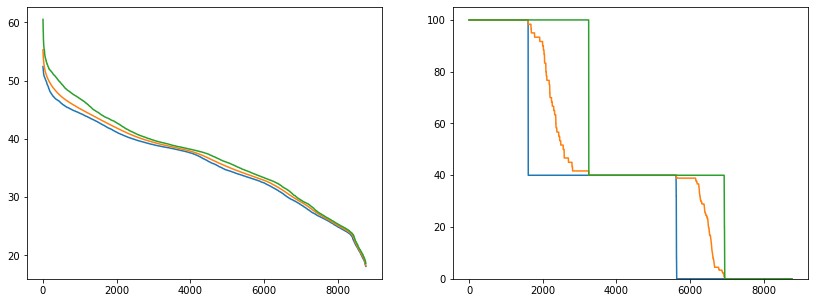

In [218]:
%matplotlib inline
import matplotlib.pyplot as plt

demand = np.sort(sims[:,2,:], axis=0)[::-1,:]
price = np.sort(sims[:,6,:], axis=0)[::-1,:]
f = plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(demand.min(axis=1))
plt.plot(demand.mean(axis=1))
plt.plot(demand.max(axis=1))
#plt.ylim((0,params['fuel']['highprice']*1.05))
plt.subplot(122)
plt.plot(price.min(axis=1))
plt.plot(price.mean(axis=1))
plt.plot(price.max(axis=1))
plt.ylim((0,params['fuel']['highprice']*1.05))
plt.show()




In [ ]:
plt.figure.size()

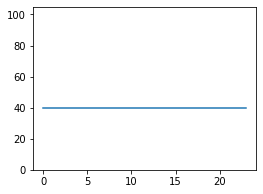

In [219]:
paths = [0]
days = [2]
i=0
col = 6 #6 for price, 2 for demand
f = plt.figure(figsize=(4*len(days),3*len(paths)))
for path in paths:
    for day in days:
        i=i+1
        axes = plt.subplot(len(paths), len(days), i)
        plt.plot(sims[day*24:(day+1)*24, col, path])
        if col==6:
            axes.set_ylim((0,params['fuel']['highprice']*1.05))

plt.show()



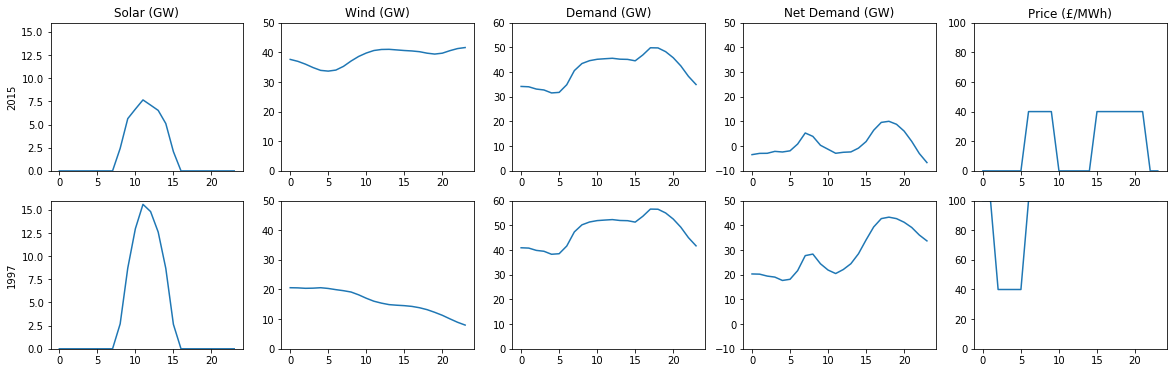

In [246]:
paths = [35, 17]
day = 0
i=0
sizes = [(0,16),(0,50),(0,60),(-10,50), (0,100)]
cols = [0,1,2,3,4]
f = plt.figure(figsize=(4*5,3*len(paths)))
for path in paths:
    for j in range(len(cols)):
        i=i+1
        axes = plt.subplot(len(paths), len(cols), i)
        plt.plot(sims[day*24:(day+1)*24, cols[j], path])
        axes.set_ylim(sizes[j])
f.axes[0].title.set_text('Solar (GW)')
f.axes[1].title.set_text('Wind (GW)')
f.axes[2].title.set_text('Demand (GW)')
f.axes[3].title.set_text('Net Demand (GW)')
f.axes[4].title.set_text('Price (£/MWh)')
f.axes[0].set_ylabel('2015')
f.axes[5].set_ylabel('1997')
plt.show()



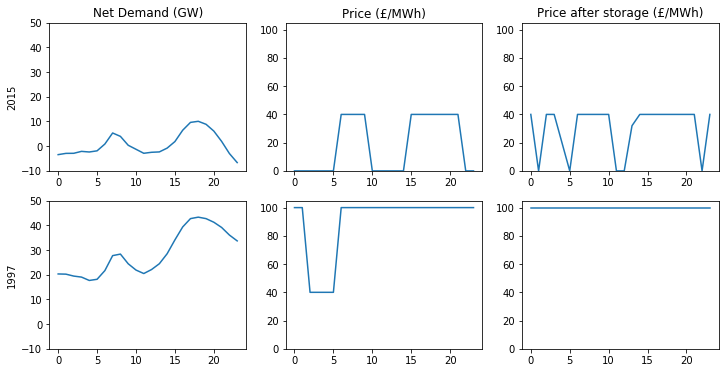

In [247]:
paths = [35, 17]
day = 0
i=0
sizes = [(-10,50),(0,105),(0,105)]
cols = [3,4,6]
f = plt.figure(figsize=(3*4,3*len(paths)))
for path in paths:
    for j in range(3):
        i=i+1
        axes = plt.subplot(len(paths), 3, i)
        plt.plot(sims[day*24:(day+1)*24, cols[j], path])
        axes.set_ylim(sizes[j])
f.axes[0].title.set_text('Net Demand (GW)')
f.axes[1].title.set_text('Price (£/MWh)')
f.axes[2].title.set_text('Price after storage (£/MWh)')
f.axes[0].set_ylabel('2015')
f.axes[3].set_ylabel('1997')
plt.show()


In [221]:
path = 35
day =0
df = pd.DataFrame(fullsims[:,:,path], columns=['solar','wind','demand','gap','rawprice','stor','price','all','solar','wind','lowprice','highprice','xhighprice'])
df.iloc[24*day:24*(day+1)]


,solar,wind,demand,gap,rawprice,stor,price,all,solar,wind,lowprice,highprice,xhighprice
0,0.00,37.60,34.18,-3.42,0.0,3.6,40.0,37.78,0.00,37.60,0.18,-0.0,-0.0
1,0.00,36.95,34.04,-2.91,0.0,2.4,0.0,36.44,0.00,36.44,-0.00,-0.0,-0.0
2,0.00,36.00,33.12,-2.88,0.0,3.6,40.0,36.72,0.00,36.00,0.72,-0.0,-0.0
3,0.00,34.85,32.75,-2.10,0.0,2.4,40.0,35.15,0.00,34.85,0.30,-0.0,-0.0
4,0.00,33.90,31.55,-2.35,0.0,2.4,20.0,33.95,0.00,33.90,0.05,-0.0,-0.0
5,0.00,33.65,31.77,-1.88,0.0,1.2,0.0,32.97,0.00,32.97,-0.00,-0.0,-0.0
6,0.00,34.00,34.87,0.87,40.0,0.0,40.0,34.87,0.00,34.00,0.87,-0.0,-0.0
7,0.00,35.25,40.59,5.34,40.0,-1.2,40.0,39.39,0.00,35.25,4.14,-0.0,-0.0
8,2.43,37.05,43.45,3.97,40.0,-3.6,40.0,39.85,2.43,37.05,0.37,-0.0,-0.0
9,5.64,38.60,44.61,0.37,40.0,0.0,40.0,44.61,5.64,38.60,0.37,-0.0,-0.0


In [289]:
ind = pd.MultiIndex.from_tuples([(100,50,12),(120,50,12),(120,60,12),(120,60,15)], names=( 'solar_capacity','wind_capacity','battery_capacity'))
df = pd.DataFrame(index=ind, columns=['solar revenue (£/MW capacity)','wind revenue (£/MW capacity)'])

tempparams = {k:v for k,v in params.items()}
table = []
for i,j in df.iterrows():
    tempparams['solarcapacity'], tempparams['windcapacity'], tempparams['batteries'] = i
    sims = compute_paths(rawsims, hourtypes, tempparams)
    d, fullsims = enrichsims(sims, tempparams)
    table.append(['{:,.0f} ({:,.0f}-{:,.0f})'.format(d.iloc[11,1], d.iloc[10,1], d.iloc[12,1]), '{:,.0f} ({:,.0f}-{:,.0f})'.format(d.iloc[11,2], d.iloc[10,2], d.iloc[12,2])])
df.values[:,:] = np.array(table)
df.reset_index()

,solar_capacity,wind_capacity,battery_capacity,solar revenue (£/MW capacity),wind revenue (£/MW capacity)
0,100,50,12,"16,686 (12,292-20,076)","92,927 (81,587-100,569)"
1,120,50,12,"12,569 (9,220-15,595)","87,623 (76,889-94,977)"
2,120,60,12,"10,632 (7,721-14,038)","65,187 (52,178-75,809)"
3,120,60,15,"10,956 (7,881-14,274)","64,175 (51,086-74,504)"
